In [ ]:
'''
A medium article about how to use Doc2Vec: https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
Gensim Documentation about Doc2Vec: https://radimrehurek.com/gensim/models/doc2vec.html
Gensim Documentation about Doc2Vec: https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py

'''

# EDA, Wrangling, and Initial Preprocessing

To start, I was choosing between these datasets:
* Customer Support on Twitter https://www.kaggle.com/thoughtvector/customer-support-on-twitter
* Ubuntu Dialogue Corpus https://www.kaggle.com/rtatman/ubuntu-dialogue-corpus
* Relational Services in Customer Service (RSICS) https://nextit-public.s3-us-west-2.amazonaws.com/rsics.html

Since I am making a chatbot for helping with application problems, the following block defines the format of intents I want to classify as the keys. The values are the predefined responses that I might want to put. This is just a toy example to illustrate this concept for context. The unsupervised learning happens in the following notebook, this notebook is just to apply my wrangling and entire preprocessing pipeline and familiarize myself with my data.

## 1. Download data and unzip it

In [1]:
!kaggle datasets download -d thoughtvector/customer-support-on-twitter

Dataset URL: https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter
License(s): CC-BY-NC-SA-4.0
100% 168M/169M [00:02<00:00, 73.4MB/s]
100% 169M/169M [00:02<00:00, 77.3MB/s]


In [2]:
!unzip customer-support-on-twitter.zip

Archive:  customer-support-on-twitter.zip
  inflating: sample.csv              
  inflating: twcs/twcs.csv           


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

import re
import nltk
# from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import casual_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import pickle

# For the counter
from collections import Counter

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

<ipython-input-3-acfdc21ec6f9>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()  # Enable tracking of execution progress


0it [00:00, ?it/s]

In [4]:
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [5]:
from google.colab import drive
drive.mount('/content/drive')

root_path = "/content/drive/MyDrive/Colab Notebooks/Topic_identification"

Mounted at /content/drive


In [6]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 6.6 MB/s eta 0:00:00


In [7]:
# save model or vectorizer or any processed data into pickle file
def save_model_to_pickle(model_name, file_name):
    pickle.dump(model_name, open(file_name, "wb"))
    print("Save model to {file_name}")


# load any model or pre-trained info from pickle file
def load_from_pickle(file_name):
    file = open(file_name, "rb")
    data = pickle.load(file)
    file.close()
    return data

# 2. Exploratory Data Analysis
I ended up settling with the Twitter data (see comparison at the back of this notebook if you're interested in why) in order to get my labelled data.

Notes about dataset:
* It's from 2017 to 2018
* From another Kernel I saw that AmazonSupport contained the most tweets, and amazingly, it turns out, not all of the tweets are in English!

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messages and no one is responding as usual,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
5,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,"@115712 Can you please send us a private message, so that I can gain further details about your account?","5,7",8.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
7,11,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,"@115713 This is saddening to hear. Please shoot us a DM, so that we can look into this for you. -KC",NaN,12.0
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your connectivity for me and my whole family ? 🤥 💯,"11,13,14",15.0
9,15,sprintcare,False,Tue Oct 31 20:03:31 +0000 2017,"@115713 We understand your concerns and we'd like for you to please send us a Direct Message, so that we can further assist you. -AA",12,16.0


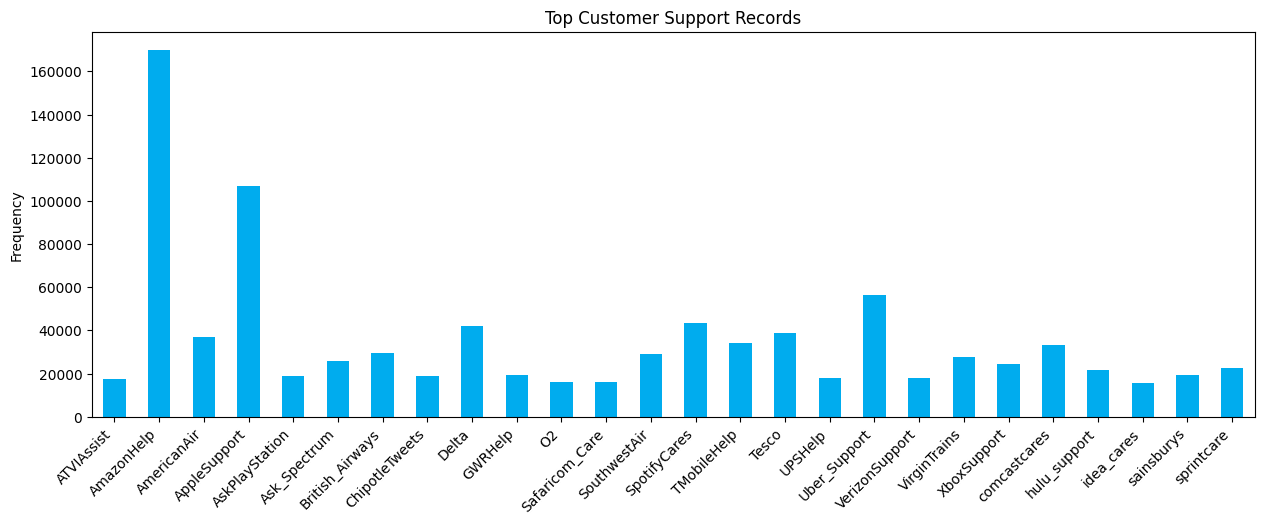

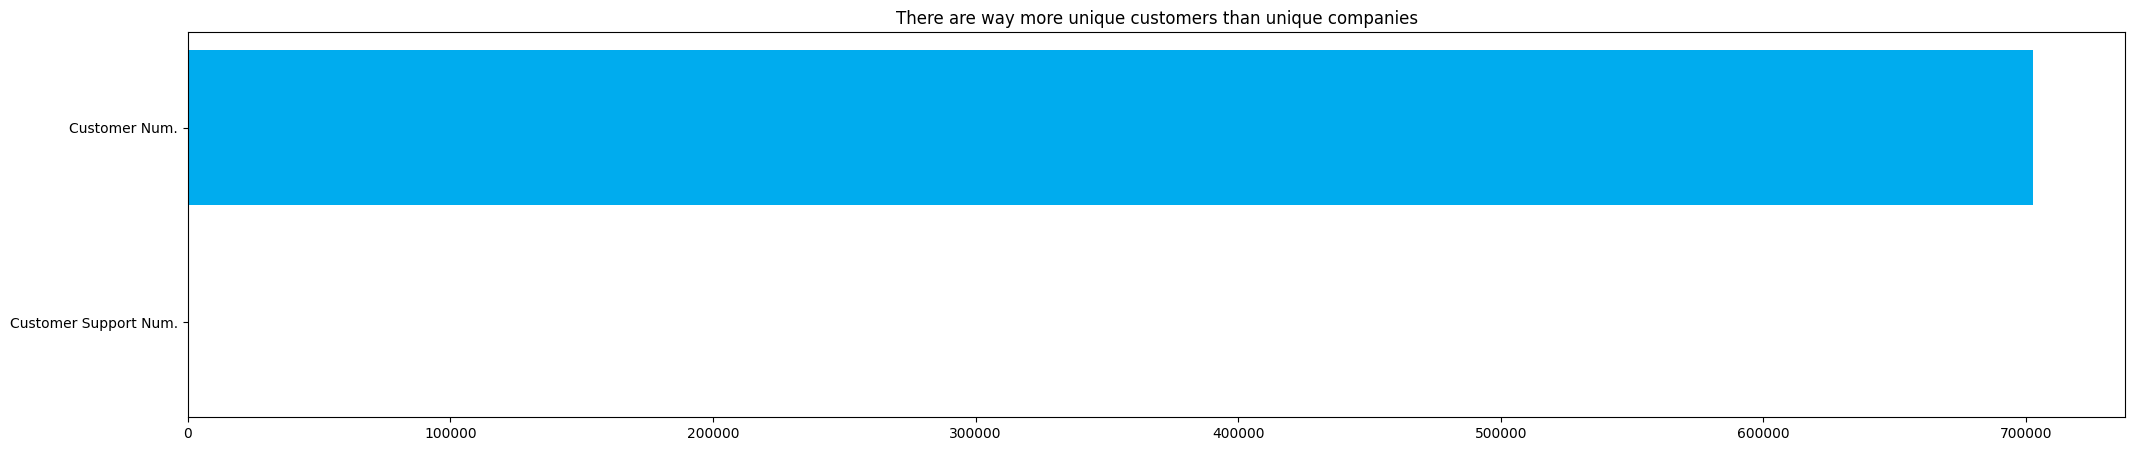

CPU times: user 26.1 s, sys: 3.24 s, total: 29.4 s
Wall time: 1min


In [8]:
%%time
# Reading in all the Twitter data
all_data = pd.read_csv('twcs/twcs.csv')
display(all_data.head(10))

# Finding the distribution of all authors
count = all_data.groupby("author_id")["text"].count()

# Showing only the authors that appear more than 15000 times
c = count[count>15000].plot(kind='bar',figsize=(15, 5), color='#00acee')
c.set_xlabel('')
c.set_ylabel('Frequency')
plt.title('Top Customer Support Records')
plt.xticks(rotation=45, ha='right')

# Saving my plot
plt.savefig('authors.png')

plt.show()

# There are 108 unique authors that are companies and 702669 customers
authors_count = (len(all_data[all_data.inbound == False].author_id.unique()), len(all_data[all_data.inbound == True].author_id.unique()))

# Visualizing it
plt.figure(figsize =(25,5))
x = ['Customer Support Num.','Customer Num.']
ax = plt.barh(x, authors_count, color = '#00acee')
plt.title('There are way more unique customers than unique companies')
plt.show()

## Data Dictionary:
* Tweet_id: The unique ID for this tweet
* Author_id: The unique ID for this tweet author (anonymized for non-company users)
* Inbound: Whether or not the tweet was sent (inbound) to a company
* Created_at: When the tweet was created
* Text: The text content of the tweet
* Response_tweet_id: The tweet that responded to this one, if any
* In_response_to_tweet_id: The tweet this tweet was in response to, if any

In [9]:
# All data shape
print('All data has shape {}'.format(all_data.shape))

# Converting columns to the right datatypes
all_data['text'] = all_data['text'].astype('string')
all_data['author_id'] = all_data['author_id'].astype('string')

# This function utilizes Panda's Style to helps me encode data type and
# magnitude information to my dataframe view
show = lambda x: x.tail(5).style.set_properties(**{'background-color': 'black',
                                    'color': 'lawngreen',
                                    'border-color': 'white'})\
.applymap(lambda x: f"color: {'lawngreen' if isinstance(x,str) else 'cyan'}")\
.background_gradient(cmap='Blues')

show(all_data)

All data has shape (2811774, 7)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this for you. Please send us a Direct Message, so that we can further assist you. -TN",nan,2987948.000000
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty service all day !! Get your shit together!,2987947,nan
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,"@143549 @sprintcare You have to go to https://t.co/v2tMHeTL7Q and ask them to add the Hulu service to your account. After you get the text, you’re good to go to https://t.co/gFyUq1kJTK",nan,2812239.000000
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.co/7uQPwyH1B6",nan,2987950.000000
2811773,2987950,823870,True,Tue Nov 21 22:01:04 +0000 2017,@AldiUK warm sloe gin mince pies with ice cream - the best thing ever! #notjustxmas#allyearround,"2987951,2987949",nan


You can see some data types are off, like the float.

In [10]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                string 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     string 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), int64(1), object(2), string(2)
memory usage: 131.4+ MB


# 3. Data Wrangling

**Requirements**:
* **Inbound**: Since the first step I want to achieve is intent classification and to figure out what the customer is saying to the company, I only want data that goes from the customer to the company (inbound data).
* **Just Apple data:** My first modeling step is to do some form of clustering to classify the intents for each of these tweets, doing so might be easier and more fruitful if I narrow the data to just the apple data because they will be in a somewhat similar domain. I can expand this over to other datasets.
* **First Tweet**

Later, I would like my chatbot to be able to respond to make *follow up* responses to my customers.

In [11]:
apple_data = all_data[all_data['author_id'] == 'AppleSupport']
apple_data.shape

(106860, 7)

There are 106860 rows of Apple data, which is 3.8 percent of the entire data. These are all data from Apple to a customer, I want the data from the customer to Apple for each of these Apple customer service responses, and this can be found in the reponse_tweet_id.

Now I drop the rows with a NaN value for the in response to tweet id column, meaning that the original customer inquiry was not available for that interaction

In [12]:
apple_data.dropna(subset = ['in_response_to_tweet_id'],inplace = True)
apple_data['inbound'].value_counts(), apple_data.shape

<ipython-input-12-3eca6e858f57>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_data.dropna(subset = ['in_response_to_tweet_id'],inplace = True)


(inbound
 False    106719
 Name: count, dtype: int64,
 (106719, 7))

Nice, it seems like we still have plenty of data to work with (106719 rows).

All of this is inbound data, because it's authored by Apple. Now I want to find all the original tweets from the customer to Apple Support and return them as a text in the Dataframe as opposed to an ID.

In other words, I change ```in_response_to_tweet_id``` from it's ID to it's text so we can see the what customer question this Apple Support Tweet was responding to.

In [13]:
# Converting the IDs to integers to match the tweet_id column for joining
apple_data.in_response_to_tweet_id = apple_data.in_response_to_tweet_id.astype('int64')


<ipython-input-13-f6c82cdbe77e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_data.in_response_to_tweet_id = apple_data.in_response_to_tweet_id.astype('int64')


In [14]:
apple_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106719 entries, 396 to 2811541
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   tweet_id                 106719 non-null  int64 
 1   author_id                106719 non-null  string
 2   inbound                  106719 non-null  bool  
 3   created_at               106719 non-null  object
 4   text                     106719 non-null  string
 5   response_tweet_id        31423 non-null   object
 6   in_response_to_tweet_id  106719 non-null  int64 
dtypes: bool(1), int64(2), object(2), string(2)
memory usage: 5.8+ MB


In [15]:
# Converting the IDs to integers to match the tweet_id column for joining
apple_data.in_response_to_tweet_id = apple_data.in_response_to_tweet_id.astype('int64')

# Doing an inner join to get the respective tweets back from the all_data from and get the response texts. So one question-answer pair is put on one record
apple_data = pd.merge(all_data[['tweet_id','text']],apple_data,left_on='tweet_id', right_on='in_response_to_tweet_id')

# Dropping the columns that doesn't encode useful information and renaming the columns nicely for intepretability
apple_data.drop(['tweet_id_x','tweet_id_y','in_response_to_tweet_id','inbound'], axis = 1, inplace = True)

# Renaming the columns for intepretability
apple_data.rename(columns = {'text_x':'inbound_text','text_y':'outbound_text'},inplace = True)


<ipython-input-15-bbdb34db77e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_data.in_response_to_tweet_id = apple_data.in_response_to_tweet_id.astype('int64')


In [16]:
# Showing the results of data wrangling
show(apple_data)

,inbound_text,author_id,created_at,outbound_text,response_tweet_id
106643,"anyone having issues with #osx #HighSierra and #Slack, #zoom or Multiple monitors? Getting major lag. @115858 @118190 @172377 #DevLife",AppleSupport,Wed Nov 22 01:02:29 +0000 2017,"@823737 We're happy to help out with your concerns. To begin, have you made sure that all apps are up-to-date via the App Store > Updates tab? Does the slower performance happen with a specific pattern? Send us a DM and we'll work on this together. https://t.co/GDrqU22YpT",2987500
106644,Hey @AppleSupport - not being able to duplicate a file in #pages when you searched for it is really annoying. What’s the fix?? https://t.co/CqnGyqNsLZ,AppleSupport,Wed Nov 22 02:33:58 +0000 2017,"@689907 We're certainly glad to get you pointed in the right direction! Please reach out in DM and let us know which iPad model you're using and the version of iOS installed, as well as which country you're tweeting from. https://t.co/GDrqU22YpT",nan
106645,Yo @AppleSupport is that weird glitch w/ the capital “I️” your attempt to make my tweets less about me? I️,AppleSupport,Wed Nov 22 02:29:26 +0000 2017,"@823765 We'd love to help! Which device are you using? The latest versions of iOS include a fix for unexpected results with Auto-Correction while typing. If you haven't had a chance, we advise backing up and updating. Here's a guide to help: https://t.co/ahjigcvFRG",nan
106646,What the fuck @AppleSupport my phone keeps hanging up calls and showing “call failure” 🤬😡,AppleSupport,Wed Nov 22 03:27:30 +0000 2017,@823779 We'd like to help. Send us a DM and we can start there. https://t.co/GDrqU22YpT,nan
106647,Is anyone having #iphone issues with there phone freezing randomly I have the 7 pulse updated to iOS 11.2 the newest version. Wtf is going on???? 🤬😡🤬😡🤬 @115858 @AppleSupport #whycan’tyouguysgetitright #stopmakingnewphonesuntillyoulearntomaketheoldonerunrite,AppleSupport,Wed Nov 22 04:15:29 +0000 2017,@823796 We'd love to offer our help in making sure your iPhone is working at peak performance. Send us a DM and let us know if you are using iOS 11.1.2 or iOS 11.2. You can confirm in Settings > General > About. https://t.co/GDrqU2kzhr,nan


Sweet. So now we are going to build off this `apple_data` from this point on.

Since we are working with unsupervised learning for the first part of my chatbot, I do not need to do a train test split. My test set would also just end up needing labels as well. For this reason, I will just subset my data to the inbound/outbound data without employing the concept of unseen data.

In [18]:
apple_data['combined_text'] = apple_data['inbound_text'] + " " + apple_data['outbound_text']
display(apple_data.head(10))
display(apple_data.info())


,inbound_text,author_id,created_at,outbound_text,response_tweet_id,combined_text
0,@AppleSupport The newest update. I️ made sure to download it yesterday.,AppleSupport,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issue. Select the following link to join us in a DM and we'll go from there. https://t.co/GDrqU22YpT,NaN,@AppleSupport The newest update. I️ made sure to download it yesterday. @115854 Lets take a closer look into this issue. Select the following link to join us in a DM and we'll go from there. https://t.co/GDrqU22YpT
1,@AppleSupport https://t.co/NV0yucs0lB,AppleSupport,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of the iOS are you running? Check from Settings &gt; General &gt; About.,697,@AppleSupport https://t.co/NV0yucs0lB @115854 We're here for you. Which version of the iOS are you running? Check from Settings &gt; General &gt; About.
2,@AppleSupport Tried resetting my settings .. restarting my phone .. all that,AppleSupport,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM us here: https://t.co/GDrqU22YpT,NaN,@AppleSupport Tried resetting my settings .. restarting my phone .. all that @115855 Let's go to DM for the next steps. DM us here: https://t.co/GDrqU22YpT
3,@AppleSupport This is what it looks like https://t.co/XCQU2l4xUB,AppleSupport,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last night?,702,@AppleSupport This is what it looks like https://t.co/XCQU2l4xUB @115855 Any steps tried since it started last night?
4,@AppleSupport I️ have an iPhone 7 Plus and yes I️ do,AppleSupport,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can rule out being outdated. Any steps tried since this started? Do you recall when it started?,"706,704",@AppleSupport I️ have an iPhone 7 Plus and yes I️ do @115855 That's great it has iOS 11.1 as we can rule out being outdated. Any steps tried since this started? Do you recall when it started?
5,@AppleSupport I️ need answers because it’s annoying 🙃,AppleSupport,Tue Oct 31 21:43:15 +0000 2017,@115855 We'd like to look into this with you. Which model do you have and is iOS 11.1 installed? Any steps tried so far?,707,@AppleSupport I️ need answers because it’s annoying 🙃 @115855 We'd like to look into this with you. Which model do you have and is iOS 11.1 installed? Any steps tried so far?
6,"Hey @AppleSupport and anyone else who upgraded to ios11.1, are y’all having issues with capital “I️” in the Mail app? As it puts in “A”?",AppleSupport,Tue Oct 31 22:26:29 +0000 2017,"@115856 Hey, let's work together to figure out what's going on. Meet us in DM and we'll continue from there. https://t.co/GDrqU22YpT",713,"Hey @AppleSupport and anyone else who upgraded to ios11.1, are y’all having issues with capital “I️” in the Mail app? As it puts in “A”? @115856 Hey, let's work together to figure out what's going on. Meet us in DM and we'll continue from there. https://t.co/GDrqU22YpT"
7,@AppleSupport This is what is happening... https://t.co/X3SZSJXfAT,AppleSupport,Tue Oct 31 22:24:54 +0000 2017,@115857 We'd like to investigate further with you. Send us a DM and we can troubleshoot more from there. https://t.co/GDrqU22YpT,NaN,@AppleSupport This is what is happening... https://t.co/X3SZSJXfAT @115857 We'd like to investigate further with you. Send us a DM and we can troubleshoot more from there. https://t.co/GDrqU22YpT
8,Tf is wrong with my keyboard @115858,AppleSupport,Tue Oct 31 22:05:00 +0000 2017,"@115857 Fill us in on what is happening, then we can help out from there.",717,"Tf is wrong with my keyboard @115858 @115857 Fill us in on what is happening, then we can help out from there."
9,@AppleSupport are the call centres closed for the night?,AppleSupport,Tue Oct 31 22:24:27 +0000 2017,@115859 We've received your DM and will continue there.,NaN,@AppleSupport are the call centres closed for the night? @115859 We've received your DM and will continue there.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106648 entries, 0 to 106647
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   inbound_text       106648 non-null  string
 1   author_id          106648 non-null  string
 2   created_at         106648 non-null  object
 3   outbound_text      106648 non-null  string
 4   response_tweet_id  31352 non-null   object
 5   combined_text      106648 non-null  string
dtypes: object(2), string(4)
memory usage: 4.9+ MB


None

This outbound data will be useful for natural langauge generation, and I might want to store the id where it points to as well.

When we process this outbound data for natural langauge generation, would this have a different preprocessing steps? Would we want it to have more complete sentences so maybe we would not try to remove the actual stop words and punctuation.

In [19]:
apple_data.info()
apple_data.to_csv(root_path + "/apple_data.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106648 entries, 0 to 106647
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   inbound_text       106648 non-null  string
 1   author_id          106648 non-null  string
 2   created_at         106648 non-null  object
 3   outbound_text      106648 non-null  string
 4   response_tweet_id  31352 non-null   object
 5   combined_text      106648 non-null  string
dtypes: object(2), string(4)
memory usage: 4.9+ MB


# 4. Text Preprocessing Pipeline
In this process, it's expected that I will find much edge cases, and I don't have to address them all. However, in the end, I felt like my preprocessing pipeline is relatively complete given this dataset.

Also, this was an iterative process because I fit my models in the next notebook just to notice that my Tweets still had '\u200d', '#', '', and '@' even though I still did a lot of fitting already. These are just emojis and extra punctuation I decided at a later stage to remove, but in the end I just modified my pipeline function.

Before that, I did a bit of EDA with bag of words to see what words are being used the most by the dataset to better preprocess the data and prevent working in too much granularity.

In [25]:
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer #Used to lemmatize words
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re
import spacy
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter
import nltk
import emoji

# the following error happens on mac
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
# the above is not needed on Windows

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
tw_tokenizer = TweetTokenizer(reduce_len=True)
nlp = spacy.load("en_core_web_sm")

# Checking the first 10 most frequent words
cnt = Counter()
for text in apple_data["inbound_text"].values:
    for word in text.split():
        cnt[word] += 1

common_words = [item[0] for item in cnt.most_common(10)]

def remove_stopwords_commonwords_lemmatizer(text):
    sent = []
    # doc = nlp(text)

    for token in tw_tokenizer.tokenize(text):
        if (token not in stop_words) and (token not in common_words):
            sent.append(token)
    return " ".join(sent)

def customize_stopwords():
  fillerWord = ("so","yeah","okay","um","uh","mmm","ahan","uh","huh","ahm","oh","sooo","uh","huh","yeh","yah","hmm","bye")
  stop_words.add(fillerWord)

  keep_words =["not","nor","neither", "no"]
  for i in keep_words:
      stop_words.discard(i)



# Converting emojis to words
def convert_emoji_to_text(emoji_text):
    text_with_aliases = emoji.demojize(emoji_text)
    return text_with_aliases


def clean_text(text):

    text = str(text).lower()
    # replace abbreviation correct misspelling words
    text = preprocess_chat_text(text)
    # text = convert_emoticons(text)
    text = convert_emoji_to_text(text)

    text = re.sub(r"https?://t.co/\S+", " ", str(text))
    text = re.sub(r"@\w+", " ", text)  # Remove placeholder [+XYZ chars]
    text = re.sub(r"\[\w+\]", " ", text)  # Remove placeholder [+XYZ chars]
    text = re.sub(r"[(/)*-]", " ", text)
    text = re.sub(r"[\.]{2,}", " ", text)  # Remove ellipsis
    text = re.sub(r"\d+", " ", text)
    # text = re.sub(r"[#@]", " ", text) # remove hashtag signs
    text = re.sub(r"yo{1,}u{1,}", "you", text)
    text = re.sub(r"ah{1,}", " relief, happy ", text)
    text = re.sub(r"alaugh\w+", "laugh", text)
    text = re.sub(r"angry{1,}", "angry", text)
    text = re.sub(r"boo{1,}m", "boom", text)
    text = re.sub(r"cherr{1,}yy{1,}", "cherry", text)
    text = re.sub(r"class{1,}y", "classy", text)
    text = re.sub(r"cu{2,}te", "cute", text)
    text = re.sub(r"fu{2,}ck\w+", "fuck", text)
    text = re.sub(r"him{2,}", "him", text)
    text = re.sub(r"(no){2,}yes", " finally ok ", text)
    text = re.sub(r"yee{1,}ss{1,}", "yes", text)
    text = re.sub(r"(no){2,}", "no", text)
    text = re.sub(r"agaa{1,}in", "again", text)
    text = re.sub(r"a{1,}g{0,}h{1,}", "angry", text)
    text = re.sub(r"a{1,}laug{0,}h{1,}", "laugh", text)
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content

    # tokens = tw_tokenizer.tokenize(text)
    # text = ""
    text = remove_stopwords_commonwords_lemmatizer(text)
    return text


def preprocess_chat_text(text):
    # Expand common abbreviations
    abbreviation_mapping = {
        ":d": "laugh",
        "lol": "laugh out loud",
        "brb": "be right back",
        "omg": "oh my god",
        "sec": "second",
        'idk': "i do not know",
        "doesn't": "does not",
        "don't": "do not",
        "didn't": "did not",
        "isn't": "is not",
        "hadn't": "had not",
        "haven't": "have not",
        "mightn't": "might not",
        "needn't": "need not",
        "wasn't": "was not",
        "weren't": "were not",
        "won't": "will not",
        "shouldn't": "should not",
        "lmao": "laughing my ass off",
        "'ve": " have",
        "I'm": "I am",
        "'s": " is",
        "can't": "can not",
        "it's": "it is",
        "you're": "you are",
        "nvm": "never mind",
        "haha": "laugh",
        "it'll": "it will",
        "'ll": " will",
        "r/": " are ",
        # Add more mappings as needed
    }

    # Replace abbreviations with their expanded forms
    for abbreviation, expansion in abbreviation_mapping.items():
        text = text.replace(abbreviation, expansion)

    # Normalize common misspellings
    misspelling_mapping = {
        "u": "you",
        "gr8": "great",
        # Add more mappings as needed
    }

    emonicons_mapping = {
       ":)": "happy",
       ":-)": "happy",
       ";)" : "happy winking",
        ";-)": "happy winking",
        ":P": "sticking out tongue",
        ":-P": "sticking out tongue",
        ":D" :	"open-mouthed grin",
        ":-D": "open-mouthed grin",
        ":(":	"unhappy",
        ":-(": "unhappy",
        ":~(": "crying",
        ":-|": "unemotional",
        ">:-(": "very unhappy",
        "8-)": "wide eyed happyness",
        ":-O": "surprise",
        ":o": "surprise",
        "8-O": "wide-eyed shouting",
        ">8-O": "mad wide-eyed shouting",
        "|-|": "asleep",
        "==|:-)": "silly",
    }

    # Replace misspelled words with their correct forms
    for misspelling, correction in misspelling_mapping.items():
        text = re.sub(r"\b{}\b".format(misspelling), correction, text)

    # Replace emoticons with their mapping words
    for emoticon, correction in emonicons_mapping.items():
        text = text.replace(emoticon, correction)
    return text

def clean_text_wrapper(df_train):
    customize_stopwords()

    # Checking the first 10 most frequent words
    cnt = Counter()
    for text in df_train["inbound_text"].values:
        for word in text.split():
            cnt[word] += 1

    cnt.most_common(10)


    print("Start cleaning...")
    df_train['clean_combined_text'] = df_train['combined_text'].apply(clean_text)
    # df_test['cleaned_text'] = df_test.inbound_text.apply(clean_text)
    print("done!")
    # df_train.to_csv("data/cleaned_train.csv", index=False)
    # df_test.to_csv("data/cleaned_test.csv", index=False)
    return df_train  #, df_test

def encode_label(df_train):
    le = LabelEncoder()
    df_train["upt_label"] = le.fit_transform(df_train['Label'])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    le_label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
    print("name maps to numeric label: ", le_name_mapping)
    print("numeric label maps to name: ", le_label_mapping)
    return le_name_mapping, le_label_mapping, df_train["upt_label"]

def encode_doc(para_max_features, para_ngram_range, train_docs, test_docs):
    vectorizer = TfidfVectorizer(max_features=para_max_features, ngram_range = para_ngram_range,  min_df=1, max_df=0.7)
    text_train = vectorizer.fit_transform(train_docs)
    text_test = vectorizer.transform(test_docs)
    tfidf_tokens = vectorizer.get_feature_names_out()
    print("text_train.shape:", text_train.shape)
    print("The first 100 tokens:", tfidf_tokens[:100])
    return text_train, text_test

def draw_piechart(df_train):
    # show pie chart for the training data distribution
    kwargs = dict(
        startangle = 90,
        autopct = '%1.1f%%',
        labels = df_train['Label'].value_counts().index,
        colors=("#048a81", "#06d6a0", "#54C6EB", "#8A89C0", "#CDA2AB"),
        radius = 0.9,
        textprops={'size': 'medium'},
    )
    fig, ax = plt.subplots(figsize=(4.8, 4.8))
    fig.subplots_adjust(top=0.7, bottom=0, right=1, left=0, hspace=0, wspace=0)
    ax.axis('equal')
    ax.margins(0, 0)
    ax.pie(df_train['Label'].value_counts(), **kwargs)
    return fig

def draw_confusion_matrix(cm, label_names):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    fig.subplots_adjust(top=0.7, bottom=0, right=0.9, left=0, hspace=0, wspace=0)

    ax.set_title("Confusion Matrix", size = 12)
    ConfusionMatrixDisplay(
        cm,
        display_labels =label_names).plot(
        include_values = True,
        cmap="Blues",
        ax=ax,
        colorbar=False)
    ax.tick_params(axis='x', which='both', bottom = False, top = False, labelbottom = True,  labelsize=9)
    return fig




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We see that after preprocessing, we will remove the handles which is what applesupport and 115858 is in the visualization above. For now, I briefly visualized the top 10 most common tokens to show that my data as it currently is quite dirty, they will definitely skew and ruin my results if I don't do preprocessing!

### Save the processed data to apple_data dataframe

In [26]:
apple_data = clean_text_wrapper(apple_data)

Start cleaning...
done!


In [27]:
apple_data.to_csv(root_path + "/apple_data.csv")
display(apple_data.head(10))
display(apple_data.info())


,inbound_text,author_id,created_at,outbound_text,response_tweet_id,combined_text,clean_combined_text
0,@AppleSupport The newest update. I️ made sure to download it yesterday.,AppleSupport,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issue. Select the following link to join us in a DM and we'll go from there. https://t.co/GDrqU22YpT,NaN,@AppleSupport The newest update. I️ made sure to download it yesterday. @115854 Lets take a closer look into this issue. Select the following link to join us in a DM and we'll go from there. https://t.co/GDrqU22YpT,newest update . made sure download yesterday . lets take closer look issue . select following link join us dm go .
1,@AppleSupport https://t.co/NV0yucs0lB,AppleSupport,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of the iOS are you running? Check from Settings &gt; General &gt; About.,697,@AppleSupport https://t.co/NV0yucs0lB @115854 We're here for you. Which version of the iOS are you running? Check from Settings &gt; General &gt; About.,we're . version ios running ? check settings > general > .
2,@AppleSupport Tried resetting my settings .. restarting my phone .. all that,AppleSupport,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM us here: https://t.co/GDrqU22YpT,NaN,@AppleSupport Tried resetting my settings .. restarting my phone .. all that @115855 Let's go to DM for the next steps. DM us here: https://t.co/GDrqU22YpT,tried resetting settings restarting phone let go dm next steps . dm us :
3,@AppleSupport This is what it looks like https://t.co/XCQU2l4xUB,AppleSupport,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last night?,702,@AppleSupport This is what it looks like https://t.co/XCQU2l4xUB @115855 Any steps tried since it started last night?,looks like steps tried since started last night ?
4,@AppleSupport I️ have an iPhone 7 Plus and yes I️ do,AppleSupport,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can rule out being outdated. Any steps tried since this started? Do you recall when it started?,"706,704",@AppleSupport I️ have an iPhone 7 Plus and yes I️ do @115855 That's great it has iOS 11.1 as we can rule out being outdated. Any steps tried since this started? Do you recall when it started?,iphone plus yes great ios . rule outdated . steps tried since started ? recall started ?
5,@AppleSupport I️ need answers because it’s annoying 🙃,AppleSupport,Tue Oct 31 21:43:15 +0000 2017,@115855 We'd like to look into this with you. Which model do you have and is iOS 11.1 installed? Any steps tried so far?,707,@AppleSupport I️ need answers because it’s annoying 🙃 @115855 We'd like to look into this with you. Which model do you have and is iOS 11.1 installed? Any steps tried so far?,need answers ’ annoying : upside down_face : we'd like look . model ios . installed ? steps tried far ?
6,"Hey @AppleSupport and anyone else who upgraded to ios11.1, are y’all having issues with capital “I️” in the Mail app? As it puts in “A”?",AppleSupport,Tue Oct 31 22:26:29 +0000 2017,"@115856 Hey, let's work together to figure out what's going on. Meet us in DM and we'll continue from there. https://t.co/GDrqU22YpT",713,"Hey @AppleSupport and anyone else who upgraded to ios11.1, are y’all having issues with capital “I️” in the Mail app? As it puts in “A”? @115856 Hey, let's work together to figure out what's going on. Meet us in DM and we'll continue from there. https://t.co/GDrqU22YpT","hey anyone else upgraded ios . , ’ issues capital “ ” mail app ? puts “ ” ? hey , let work together figure going . meet us dm continue ."
7,@AppleSupport This is what is happening... https://t.co/X3SZSJXfAT,AppleSupport,Tue Oct 31 22:24:54 +0000 2017,@115857 We'd like to investigate further with you. Send us a DM and we can troubleshoot more from there. https://t.co/GDrqU22YpT,NaN,@AppleSupport This is what is happening... https://t.co/X3SZSJXfAT @115857 We'd like to investigate furt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106648 entries, 0 to 106647
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   inbound_text         106648 non-null  string
 1   author_id            106648 non-null  string
 2   created_at           106648 non-null  object
 3   outbound_text        106648 non-null  string
 4   response_tweet_id    31352 non-null   object
 5   combined_text        106648 non-null  string
 6   clean_combined_text  106648 non-null  object
dtypes: object(3), string(4)
memory usage: 5.7+ MB


None

# 5. Document Vectorizing


### Use Doc2Vec and save the model
This is a way that was developed for word2vec to generalize to paragraphs. Doc2Vec takes the average across them, and each tweet is represented as a single embedding so you have consistent dimensionality.

Word2Vec uses Continuous Bag of Words, which creates a sliding window around each word to predict it from context (surrouding words), and the Skip Gram model. Doc2Vec is based off that.

* https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
* https://radimrehurek.com/gensim/models/doc2vec.html
* https://rare-technologies.com/doc2vec-tutorial/

It's basically word to vec, but basically takes the standard word to vec model and adds in an extra vector to represent the paragraph - called a paragraph vector. Take in sequences of words, then they use them to predict the next word and check if that prediction is correct. If the prediction is correct, it does this multiple times for different combinations of words.

It's the same as word2vec, but at a document level as opposed to a word level. My implementation below had it's base from [here](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e) and from scrolling through Gensim's documentation for a more granular understanding of each step.

In [28]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument, Word2Vec

def train_doc2vec(string_data, max_epochs, vec_size, alpha):
    # Tagging each of the data with an ID, and I use the most memory efficient one of just using it's ID
    tagged_data = [TaggedDocument(words=_d.split(), tags=[str(i)])
                   for i, _d in enumerate(string_data)]

    # C: Note: dm defines the training algorithm. If dm=1 means ‘distributed memory’ (PV-DM) and dm =0 means ‘distributed bag of words’ (PV-DBOW). Distributed Memory model preserves the word order in a document whereas Distributed Bag of words just uses the bag of words approach, which doesn’t preserve any word order.
    # Instantiating my model
    dv_model = Doc2Vec(vector_size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm =1)

    dv_model.build_vocab(tagged_data)

    for epoch in range(max_epochs):
        print('iteration {0}'.format(epoch))
        dv_model.train(tagged_data, total_examples = dv_model.corpus_count, epochs=dv_model.epochs)
        # Decrease the learning rate
        dv_model.alpha -= 0.0002
        # Fix the learning rate, no decay
        dv_model.min_alpha = dv_model.alpha

    # Saving model
    # dv_model.save(root_path + "/d2v.model")
    save_model_to_pickle(dv_model, root_path + "/dv_model.pkl")
    return dv_model

# Training
dv_model = train_doc2vec(apple_data['clean_combined_text'], max_epochs = 10, vec_size = 50, alpha = 0.025)

iteration 0


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Save model to {file_name}


### Use TFIDF and save the model

In [ ]:
def generate_tfidf_vectors(series):
    vectorizer = TfidfVectorizer(max_features=3000, ngram_range = (1, 2),  min_df=3, max_df=0.7)
    doc_vectors = vectorizer.fit_transform(series)
    tfidf_tokens = vectorizer.get_feature_names_out()
    save_model_to_pickle(vectorizer, root_path + "/tfidf_vectorizer.pkl")
    save_model_to_pickle(doc_vectors, root_path + "/tfidf_result.pkl")
    print("The first 10 tokens:", tfidf_tokens[:10])

    return vectorizer, doc_vectors, tfidf_tokens

# apple_data['clean_combined_text'] = apple_data['clean_combined_text'].fillna("")
tfidf_vectorizer, tfidf_result, tfidf_tokens = generate_tfidf_vectors(apple_data['clean_combined_text'])

Save model to {file_name}
Save model to {file_name}
The first 10 tokens: ['ability' 'able' 'able enjoy' 'able get' 'able help' 'able update'
 'able use' 'absolute' 'absolutely' 'accept']


## Use Word2Vec to save the model

In [ ]:
# this function wraps up the operations of word vectorization and doc vectorization. Return values:
# word_vectorizer - word2Vec object
# vectorized_doc - list of list, each sub list represents an abstract's vector
def generate_word_and_doc_vectors(series):
    # use word2vec to tokenize the whole abstract field and save to pickle
    # Note: running this step needs 30+ mins.
    tokenized_docs = series.str.split()
    word_vectorizer = Word2Vec(sentences=tokenized_docs, vector_size=300, workers=1, seed=42)
    print("Generating word vectors... Take 30+ mins.")
    save_model_to_pickle(word_vectorizer, root_path + "/w2v_model.pkl")

    # vectorize each document into ONE representative vector and save to pickle
    # this step needs 10+ mins.
    vectorized_result = vectorize(tokenized_docs, model=word_vectorizer)
    print("vectorized_docs shape: samples - {}, each sample dimension - {}".format(len(vectorized_result), len(vectorized_result[0])))
    save_model_to_pickle(vectorized_result, root_path + "/w2v_vectorized_doc.pkl")

    return word_vectorizer, vectorized_result


# vectorize all the docs
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding"""
    features = []
    for index, doc in enumerate(list_of_docs):
        if index % 5000 == 0:
          print("Starting vectorizing docs {}-{}".format(index, index+5000))
        # if the doc has one or more tokens being found in the dimension of word features, convert them to narray, and calculate the mean
        avg_vec = vectorize_single_doc(doc, model)
        features.append(avg_vec)
    print("Finish vectorizing all the docs.")
    return features


# clean up user's input and vectorize the input doc as a vector
def generate_vector_for_user_input(user_input, vectorizer):
  processed_token = clean_text(user_input).split()
  new_vector = vectorize_single_doc(processed_token, vectorizer)
  return new_vector

# get average of each word vector to represent the doc
def vectorize_single_doc(tokenized_doc, model):

  vectors = []
  for token in tokenized_doc:
      # if this token belongs to the word dimension of the model
      if token in model.wv:
          try:
              # get the word vector name
              vectors.append(model.wv[token])
          except KeyError:
              continue
  # if the doc has one or more tokens being found in the dimension of word features, convert them to narray, and calculate the mean
  if vectors:
      vectors = np.asarray(vectors)
      avg_vec = vectors.mean(axis=0)
      return avg_vec
  else:
    # the dimension of word2vec in the model
      return np.zeros(model.vector_size)

In [ ]:
wv_vectorizer, wv_result = generate_word_and_doc_vectors(apple_data['clean_combined_text'])


Generating word vectors... Take 30+ mins.
Save model to {file_name}
Starting vectorizing docs 0-5000
Starting vectorizing docs 5000-10000
Starting vectorizing docs 10000-15000
Starting vectorizing docs 15000-20000
Starting vectorizing docs 20000-25000
Starting vectorizing docs 25000-30000
Starting vectorizing docs 30000-35000
Starting vectorizing docs 35000-40000
Starting vectorizing docs 40000-45000
Starting vectorizing docs 45000-50000
Starting vectorizing docs 50000-55000
Starting vectorizing docs 55000-60000
Starting vectorizing docs 60000-65000
Starting vectorizing docs 65000-70000
Starting vectorizing docs 70000-75000
Starting vectorizing docs 75000-80000
Starting vectorizing docs 80000-85000
Starting vectorizing docs 85000-90000
Starting vectorizing docs 90000-95000
Starting vectorizing docs 95000-100000
Starting vectorizing docs 100000-105000
Starting vectorizing docs 105000-110000
Finish vectorizing all the docs.
vectorized_docs shape: samples - 106648, each sample dimension -

AttributeError: 'list' object has no attribute 'shape'

## Use Transformer embedding

In [23]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [28]:

from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2")
                                    #   device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)
#
# Create a list of sentences to turn into numbers
# sentences = [
#     "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
#     "Sentences can be embedded one by one or as a list of strings.",
#     "Embeddings are one of the most powerful concepts in machine learning!",
#     "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
# ]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(list(apple_data['clean_combined_text']), batch_size=32)
# embeddings_dict = dict(zip(sentences, embeddings))

# # See the embeddings
# for sentence, embedding in embeddings_dict.items():
#     print("Sentence:", sentence)
#     print("Embedding:", embedding)
#     print("")

In [33]:
len(embeddings), len(embeddings[0])

(106648, 768)

In [35]:
save_model_to_pickle(embedding_model, root_path + "sentence_transformer.pkl")
save_model_to_pickle(embeddings, root_path + "sentence_transformer_result.pkl")

Save model to {file_name}
Save model to {file_name}


## Play around Doc2Vec

In [ ]:
dv_model.wv.similar_by_word("battery")

[('batter', 0.7063205242156982),
 ('episode', 0.6188691854476929),
 ('batt', 0.6009058952331543),
 ('workout', 0.5746048092842102),
 ('eventually', 0.5428136587142944),
 ('reinstalling', 0.5368268489837646),
 ('batery', 0.521278440952301),
 ('order', 0.5126808285713196),
 ('#battery', 0.5062965154647827),
 ('relying', 0.49928438663482666)]

### Directly using Doc2Vec's most_similar method, the result looks strange

In [ ]:
sentence_vector = dv_model.infer_vector(['phone', 'screen', 'is', 'broken'])
top_similar_docs = dv_model.dv.most_similar(positive=sentence_vector, topn=10)
display(top_similar_docs)

[('57909', 0.7511110305786133),
 ('76772', 0.7308211922645569),
 ('53840', 0.7290232181549072),
 ('49936', 0.727785050868988),
 ('75633', 0.7239804863929749),
 ('54758', 0.7230312824249268),
 ('55104', 0.7173165082931519),
 ('50574', 0.7161725163459778),
 ('78180', 0.7156147360801697),
 ('55543', 0.7112165093421936)]

In [ ]:
for idx, _ in enumerate(top_similar_docs):
    print(apple_data.iloc[int(idx)]["clean_combined_text"])
    print(apple_data.iloc[int(idx)]['outbound_text'])
    print("")

newest update . made sure download yesterday . lets take closer look issue . select following link join us dm go . LINK
@115854 Lets take a closer look into this issue. Select the following link to join us in a DM and we'll go from there. https://t.co/GDrqU22YpT

LINK we're . version ios running ? check settings > general > .
@115854 We're here for you. Which version of the iOS are you running? Check from Settings &gt; General &gt; About.

tried resetting settings restarting phone let go dm next steps . dm us : LINK
@115855 Let's go to DM for the next steps. DM us here: https://t.co/GDrqU22YpT

looks like LINK steps tried since started last night ?
@115855 Any steps tried since it started last night?

iphone plus yes great ios . rule outdated . steps tried since started ? recall started ?
@115855 That's great it has iOS 11.1 as we can rule out being outdated. Any steps tried since this started? Do you recall when it started?

need answers ’ annoying : upside down_face : we'd like look 

In [ ]:
dv_model.similarity_unseen_docs(["phone screen is broken"], ["screen is craked"])

-0.015350139

In [ ]:
dv_model.corpus_total_words

2852134

In [ ]:
display(dv_model.dv.similarity(2, 3))
display(apple_data.iloc[2]['clean_combined_text'])
display(apple_data.iloc[3]['clean_combined_text'])

0.056289855

'tried resetting settings restarting phone let go dm next steps . dm us : LINK'

'looks like LINK steps tried since started last night ?'

# 5. K Means
My first approach for the clustering my doc vectors is K-Means.

A drawback is that it is very slow, and picking the value for K is hard - I don't even know how many intents there are in the data. This is why I start with larger jumps of K to get a higher level idea of which performs the best, then I dive deeper to finally decide what K works the best for finding the optimal number of intents in my dataset.

In [25]:
apple_data = pd.read_csv(root_path + "/apple_data.csv")
apple_data = apple_data[apple_data['created_at'].notna()]
apple_data['clean_combined_text'].fillna("", inplace=True)
k = 10

<ipython-input-25-691d3e80ba05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_data['clean_combined_text'].fillna("", inplace=True)


In [26]:
apple_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106648 entries, 0 to 106668
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Unnamed: 0           106648 non-null  object
 1   inbound_text         106648 non-null  object
 2   author_id            106648 non-null  object
 3   created_at           106648 non-null  object
 4   outbound_text        106644 non-null  object
 5   response_tweet_id    31356 non-null   object
 6   combined_text        106643 non-null  object
 7   clean_combined_text  106648 non-null  object
dtypes: object(8)
memory usage: 7.3+ MB


## Use Doc2Vec model to fit into KMeans

In [ ]:
dv_model = load_from_pickle(root_path + "/dv_model.pkl")

In [ ]:
len(dv_model.dv)

106648

In [ ]:
apple_data.shape

(106648, 7)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

k = 10
print(f'Currently fitting with {k} clusters... Please wait')

# Initializing with k-means++ ensures that you get don’t fall into the random initialization trap.
dv_km_model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state = 10)
y_pred = dv_km_model.fit_transform(dv_model.dv[range(len(dv_model.dv))])
display(dv_km_model.labels_[:20])

Currently fitting with 10 clusters... Please wait


array([6, 0, 9, 6, 7, 7, 7, 3, 3, 6, 3, 6, 2, 3, 9, 3, 2, 9, 4, 3],
      dtype=int32)

In [ ]:
save_model_to_pickle(dv_km_model, root_path + "/dv_km_model.pkl")

Save model to {file_name}


In [ ]:
len(dv_km_model.labels_)

106648

In [ ]:
# 10 centers of 10 clusters
dv_km_model.cluster_centers_

In [ ]:
new_input_vector = dv_model.infer_vector(["what", "is", "the", "problem", "of", "the", "screen", "flicking"])
new_input_vector

array([ 8.5378937e-02, -3.0386886e-01, -2.8016421e-01, -1.5703404e-01,
       -1.9799322e-01, -4.6742463e-01, -6.2798268e-01, -1.0586858e-02,
       -5.1402932e-01, -2.0957710e-01,  1.9833174e-01,  4.3096560e-01,
       -1.2741126e-01, -4.1207889e-01, -1.3794434e-01, -2.1881707e-01,
        2.9866597e-01, -4.1656074e-01,  6.5303311e-02, -2.1282031e-01,
        2.9483578e-01, -2.4179663e-01, -1.2740947e-02, -2.5054613e-01,
        1.3746469e-01, -2.7787991e-02, -1.7367049e-01, -2.3385948e-01,
        3.0535325e-01,  3.5429335e-01,  6.1980432e-01, -4.2817292e-01,
       -3.4887585e-01, -5.3959537e-01,  1.0401572e-01, -5.1108938e-02,
       -4.7548008e-01,  3.1888902e-01,  4.5366317e-01, -4.7587696e-01,
        1.4093047e-01, -1.7555263e-02,  1.4099050e-01,  5.1777255e-02,
       -1.0640571e-01,  3.3449486e-01,  2.5906819e-01,  1.9678846e-04,
       -1.9528104e-01,  6.0426150e-02], dtype=float32)

In [ ]:
dv_km_model.predict(new_input_vector.reshape(1, -1))

array([8], dtype=int32)

In [ ]:
# find all the inbount_text which belongs to specified cluster
for i in range(10):
    data_df = apple_data[dv_km_model.labels_ == i]
    print(f"\n\nCluster {i+1}:")
    print(data_df['clean_combined_text'][:10])




Cluster 0:
1                                                                                                                      LINK we're . version ios running ? check settings > general > .
25                                               hey ! last time downloaded update freaking phone gave hell . recommendations ? we're help . meet us dm check available options . LINK
29                                                                        need something battery life sucks ass want help get battery life back track . please dm look together . LINK
46                                                                                                   no . . says . update ima go relief , happy ead please keep us posted afterwards .
68                                                                                            newest version ios iphone since released ios . today , clarify exact version installed ?
86                                                             ios . key

## Use Word2Vec to fit into KMeans model

In [ ]:
w2v_result = load_from_pickle(root_path + "/w2v_vectorized_doc.pkl")
apple_data = pd.read_csv(root_path + "/apple_data.csv")

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

print(f'Currently fitting with {k} clusters... Please wait')

# Initializing with k-means++ ensures that you get don’t fall into the random initialization trap.
wv_km_model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state = 10)
y_pred = wv_km_model.fit_transform(wv_result)
display(wv_km_model.labels_[:20])


Currently fitting with 10 clusters... Please wait


array([5, 0, 5, 3, 1, 4, 1, 5, 8, 9, 9, 5, 9, 9, 0, 1, 0, 4, 0, 4],
      dtype=int32)

In [ ]:
# find all the inbount_text which belongs to specified cluster
for i in range(10):
    data_df = apple_data[wv_km_model.labels_ == i]
    print(f"\n\nCluster {i+1}:")
    print(data_df['clean_combined_text'][:10])



Cluster 0:
1                                                                                                                                   LINK we're . version ios running ? check settings > general > .
14                                                                                        iphone plus recent update . make sure , ios . installed currently ? also , steps tried far ? dm us : LINK
16                                                                           ios . . let check settings > general > software update . ios . released earlier today . see , please backup & update .
18                                                                                     iphone plus : smiling_face_with_smiling_eyes : thanks ! ios version currently showing settings > general > ?
33                                                                                    ios killing battery . fix . we're help . exact ios version device running ? info found settings > general > .
38     

## Use TFIDF to fit into KMeans model

In [ ]:
tfidf_result = load_from_pickle(root_path + "/tfidf_result.pkl")
apple_data = pd.read_csv(root_path + "/apple_data.csv")

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

k = 10
print(f'Currently fitting with {k} clusters... Please wait')

# Initializing with k-means++ ensures that you get don’t fall into the random initialization trap.
tfidf_km_model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state = 10)
y_pred = tfidf_km_model.fit_transform(tfidf_result)
display(tfidf_km_model.labels_[:20])

Currently fitting with 10 clusters... Please wait


array([7, 1, 3, 0, 9, 0, 7, 7, 0, 0, 0, 7, 4, 4, 0, 0, 1, 0, 1, 0],
      dtype=int32)

In [ ]:
tfidf_result.shape

(106648, 3000)

In [ ]:
# find all the inbount_text which belongs to specified cluster
for i in range(10):
    data_df = apple_data[tfidf_km_model.labels_ == i]
    print(f"\n\nCluster {i+1}:")
    print(data_df['clean_combined_text'][:10])



Cluster 0:
3                                                                                                                  looks like LINK steps tried since started last night ?
5                                                                 need answers ’ annoying : upside down_face : we'd like look . model ios . installed ? steps tried far ?
8                                                                                                                            tf wrong keyboard fill us happening , help .
9                                                                                                                      call centres closed night ? received dm continue .
10                                                                                                        hello lines closed tonight #help going ? we're hapy help . LINK
14                                                              iphone plus recent update . make sure , ios . installed currently ? also 

## Use Sentence Transformer to feed into KMeans model

In [ ]:
embeddings = load_from_pickle(root_path + "/sentence_transformer_result.pkl")

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

k = 10
print(f'Currently fitting with {k} clusters... Please wait')

# Initializing with k-means++ ensures that you get don’t fall into the random initialization trap.
st_km_model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state = 10)
y_pred = st_km_model.fit_transform(embeddings)
display(dv_km_model.labels_[:20])

Currently fitting with 10 clusters... Please wait


array([9, 8, 8, 9, 1, 1, 3, 9, 3, 2, 2, 2, 3, 1, 4, 4, 4, 9, 8, 0],
      dtype=int32)

In [38]:
# find all the inbount_text which belongs to specified cluster
for i in range(10):
    data_df = apple_data[st_km_model.labels_ == i]
    print(f"\n\nCluster {i+1}:")
    print(data_df['clean_combined_text'][:10])



Cluster 1:
19           need software update urgently . battery lasts literally half day :p erson_frowning_medium light_skin_tone :: slightly_frowning_face : hi ! type device working ?
29                                                                    need something battery life sucks ass want help get battery life back track . please dm look together .
33                                                              ios killing battery . fix . we're help . exact ios version device running ? info found settings > general > .
39                                                                                                        battery life got worst . make sure get straightened . dm us , see .
51           battery life short ? updated . , battery poor . wife ’ likes battery life let ’ work together situation . clarify , start updating ios . ? also , device using ?
56                 question iphone dies quick charge times day iphone battery faulty . could ? know important battery